# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Exploratory Data Analysis

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Create function to print image
def print_image(img_path):
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()

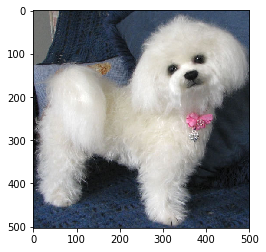

In [4]:
print_image(test_files[103])

In [5]:
from PIL import Image
# Check width and height of the images
im = Image.open(test_files[108])
width, height = im.size
print(width)
print(height)

308
442


In [6]:
from PIL import Image
# Get the number of pixels of each image in train_files
image_pixels = []
for img in train_files:
    im = Image.open(img)
    width, height = im.size
    pixels = width*height
    image_pixels.append(pixels)

In [7]:
# The mean number of pixels in the training set is
print("The mean number of pixels in the training set is " + str(round(np.mean(image_pixels),1).astype('int64')) + ".")

The mean number of pixels in the training set is 422259.


In [8]:
# Function that takes in a string a returns the substring after a specified delimiter
def substring_after(s, delim):
    return s.partition(delim)[2]
# Function that takes in a string a returns the substring before a specified delimiter
def substring_before(s, delim):
    return s.partition(delim)[0]
# Function that takes in a path to an image (representing a string value) and a delimiter; based on this it returns the dog
# name that is part of the image path (representing the dog breed shown in the image)
def dog_name_extractor(image_path, deliminator):
    s = image_path
    s_temp = substring_after(s, deliminator)
    s_temp_2 = substring_after(s_temp, '.')
    dog_name = substring_before(s_temp_2, '/')
    return dog_name

In [9]:
# Test the function
dog_name_extractor(valid_files[1], '../../../data/dog_images/valid/')

'Labrador_retriever'

In [10]:
import pandas as pd
# Get the dog names for every file in the train set
train_list = []
counter = 0
for img in train_files:
    dog_name = dog_name_extractor(train_files[counter], '../../../data/dog_images/train/')
    train_list.append(dog_name)
    counter = counter + 1
# Convert results list to data frame
dog_names_train = pd.DataFrame({'dog_names':train_list})
dog_names_train.head(5)

,dog_names
0,Kuvasz
1,Dalmatian
2,Irish_water_spaniel
3,American_staffordshire_terrier
4,American_staffordshire_terrier


In [11]:
# Get the value counts for the train set
dog_names_train['dog_names'].value_counts()

Alaskan_malamute                  77
Border_collie                     74
Basset_hound                      73
Dalmatian                         71
Bullmastiff                       69
Bull_terrier                      69
Basenji                           69
Cavalier_king_charles_spaniel     67
Australian_cattle_dog             66
Irish_terrier                     66
American_staffordshire_terrier    66
Australian_shepherd               66
Briard                            65
Boston_terrier                    65
Bernese_mountain_dog              65
Dachshund                         65
American_eskimo_dog               64
Boxer                             64
Golden_retriever                  64
Bloodhound                        64
Affenpinscher                     64
Belgian_sheepdog                  64
Cane_corso                        64
Cairn_terrier                     63
Papillon                          63
Akita                             63
Flat-coated_retriever             63
B

In [12]:
# Get some descriptive statistics on the dog names in the train set
print(dog_names_train['dog_names'].value_counts().mean())
print(dog_names_train['dog_names'].value_counts().max())
print(dog_names_train['dog_names'].value_counts().min())

50.2255639098
77
26


We can see that the average appearance of a dog breed is around 50 times in the train set. While one breed appears 77 times, the breed with the lowest count only appears 26 times. This suggests that while the breeds are not evenly distributed, the dataset does not seem to be extremely imbalanced.

Text(0.5,1,'The 10 Most Common Dogbreeds in the Training Set')

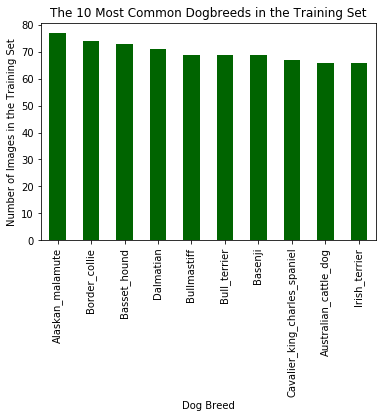

In [13]:
# Plot the ten most frequent dog breeds in the training set
dog_names_train['dog_names'].value_counts().sort_values(ascending=False).head(10).plot(kind = 'bar', color = 'darkgreen')
plt.xlabel('Dog Breed')
plt.ylabel('Number of Images in the Training Set')
plt.title('The 10 Most Common Dogbreeds in the Training Set')

In [14]:
# Get the dog names for every file in the test set
test_list = []
counter = 0
for img in test_files:
    dog_name = dog_name_extractor(test_files[counter], '../../../data/dog_images/test/')
    test_list.append(dog_name)
    counter = counter + 1
# Convert results list to data frame
dog_names_test = pd.DataFrame({'dog_names':test_list})

In [15]:
# Get some descriptive statistics on the dog names in the test set
print(dog_names_test['dog_names'].value_counts().mean())
print(dog_names_test['dog_names'].value_counts().max())
print(dog_names_test['dog_names'].value_counts().min())

6.28571428571
10
3


Text(0.5,1,'The 10 Most Common Dogbreeds in the Test Set')

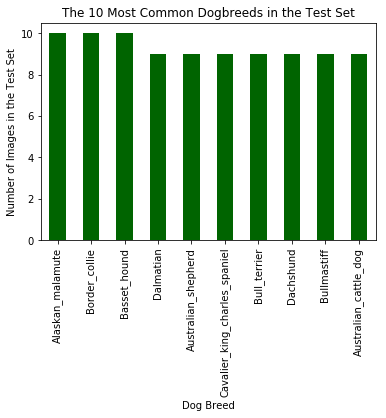

In [16]:
# Plot the ten most frequent dog breeds in the test set
dog_names_test['dog_names'].value_counts().sort_values(ascending=False).head(10).plot(kind = 'bar', color = 'darkgreen')
plt.xlabel('Dog Breed')
plt.ylabel('Number of Images in the Test Set')
plt.title('The 10 Most Common Dogbreeds in the Test Set')

In [17]:
# Get the dog names for every file in the validation set
valid_list = []
counter = 0
for img in valid_files:
    dog_name = dog_name_extractor(valid_files[counter], '../../../data/dog_images/valid/')
    valid_list.append(dog_name)
    counter = counter + 1
# Convert results list to data frame
dog_names_valid = pd.DataFrame({'dog_names':valid_list})

In [18]:
# Get some descriptive statistics on the dog names in the validation set
print(dog_names_valid['dog_names'].value_counts().mean())
print(dog_names_valid['dog_names'].value_counts().max())
print(dog_names_valid['dog_names'].value_counts().min())

6.27819548872
9
4


Text(0.5,1,'The 10 Most Common Dogbreeds in the Validation Set')

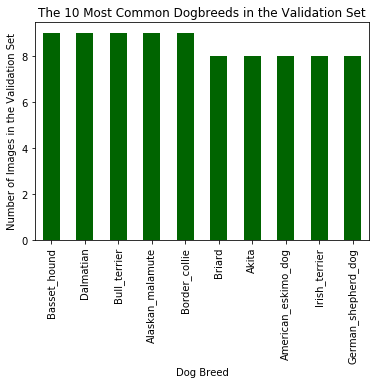

In [19]:
# Plot the ten most frequent dog breeds in the validation set
dog_names_valid['dog_names'].value_counts().sort_values(ascending=False).head(10).plot(kind = 'bar', color = 'darkgreen')
plt.xlabel('Dog Breed')
plt.ylabel('Number of Images in the Validation Set')
plt.title('The 10 Most Common Dogbreeds in the Validation Set')

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [35]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


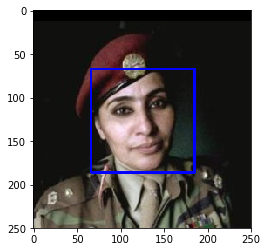

In [37]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [38]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

Out of the first 100 images of the humans dataset, 100.0 % were classified as depicting a human face. Out of the first 100 images of the dogs dataset, 11.0 % were classified as depicting a human face.

In [39]:
# Take the first 100 images of both datasets
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

# Initiate counter for dataset loop - we will loop over the two datasets
i = 0

# Loop over the two datasets
for i in range(2):
    
    # Empty list for human face classification
    human_classification_list = []
    # Initiate counter
    image = 0
    # Select relevant data set
    if i == 1:
        images = human_files_short
        dataset_name = 'humans'
    else:
        images = dog_files_short
        dataset_name = 'dogs'
    
    # Classify every image and add result (TRUE or FALSE) to human classification list
    for image in range(len(images)):
        # Classify image
        human_flg = face_detector(images[image])
        # Add classification to list
        human_classification_list.append(human_flg)
        # Update counter
        image = image + 1
        
    # Print results
    print("Out of the first 100 images of the " + str(dataset_name) + " dataset, " + str(round((sum(human_classification_list)/100)*100,1)) + " % were classified as human.")    
    
    # Update dataset counter
    i = i + 1
    
##### Results
# Out of the first 100 images of the dogs dataset, 11.0 % were classified as human.
# Out of the first 100 images of the humans dataset, 100.0 % were classified as human.

Out of the first 100 images of the dogs dataset, 11.0 % were classified as human.
Out of the first 100 images of the humans dataset, 100.0 % were classified as human.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

In my opinion, one can mention this expectation to the users. However, one should not expect that they comply with it. Instead, we could expect that despite this recommendation many users will upload images that do not contain a clearly presented face.
Therefore, I would suggest improving the algorithm (like mentioned below). More importantly, we should extend our dataset to also include images with not clearly presented faces to improve the algorithm so that it can detect humans in images without cleary presented faces.

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [23]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [22]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 5s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [23]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [24]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [25]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

Out of the first 100 images of the dogs dataset, 100.0 % were classified as dogs. Out of the first 100 images of the humans dataset, 0.0 % were classified as dogs.

In [28]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

i = 0

# Loop over the two datasets
for i in range(2):
    
    # Empty list for human picture classification
    dog_classification_list = []
    # Initiate counter
    image_counter = 0
    # Select relevant data set
    if i == 1:
        images = human_files_short
        dataset_name = 'humans'
    else:
        images = dog_files_short
        dataset_name = 'dogs'
    
    # Classify every image and add result (TRUE or FALSE) to dog classification list
    for image_counter in range(len(images)):
    # Classify image
        dog_flg = dog_detector(images[image_counter])
        # Add classification to list
        dog_classification_list.append(dog_flg)
        # Update counter
        image_counter = image_counter + 1
        
    # Print results
    print("Out of the first 100 images of the " + str(dataset_name) + " dataset, " + str(round((sum(dog_classification_list)/100)*100,1)) + " % were classified as dogs.")    
    
    # Update dataset counter
    i = i + 1
    
###### Results
# Out of the first 100 images of the dogs dataset, 100.0 % were classified as dogs.
# Out of the first 100 images of the humans dataset, 0.0 % were classified as dogs.

Out of the first 100 images of the dogs dataset, 100.0 % were classified as dogs.
Out of the first 100 images of the humans dataset, 0.0 % were classified as dogs.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [26]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 110.08it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In general, using a CNN to identify dog breeds is very reasonably for this task and dataset at hand as we only have a relatively small training set consisting of 6,680 images, while our images tend to have a lot of features (224 times 224 times 3). Therefore, we need to rely on CNNs to reduce this complexity to tackle this classification task.

Furthermore, from my perspective, the model should be rather simple as our training set only consists of 6,680 images. Therefore, creating a very deep network with many layers or a large number of channels won't work out. This insight motivates only using three convolutional and four pooling (including global average pooling) layers.

In addition, the choice of "ReLU" as the activation function is rather natural as this activation function has proven itself across many deep learning tasks (e.g., it helps to avoid vanishing gradients). However, I would assume that other activation function (e.g., Sigmoid) would also work fine.

The window size of 2 times 2 is motivated by the fact that different dog breeds tend to differ only slightly (as mentioned above). Therefore, we would not want to large windows which could ommit those differences.

Increasing the number of channels from layer to layer (while decreasing the width and height) is the standard approach to detect more and more complex features. On the other hand, the pooling layers help to keep the complexity manageable while increasing the number of channels.

While I have tried to improve the performance on the model by adapting the proposed architecture, I was not able to do so and only achieved a test accuracy of around 0.95% when using more layers and drop out. The test archictecure that I developed is contained in the cell starting with "Testing Area".


In [27]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
import tensorflow as tf


### TODO: Define your architecture.

model = Sequential()

# Tensors of shape (1,224,224,3) based on preprocessing as input ("input_shape")
# 16 = number of channels (filters)
# 2 = kernel_size represents window size
# activation = "relu": activation function Rectified Linear Activation which tends to work well for CNNs
# Output = Input - kernel_size + 1 (no strides (=1) or padding is applied)
model.add(Conv2D(filters = 16,kernel_size = 2, activation="relu", input_shape=(224,224,3)))

# Pooling layer reducity the complexity (reducing width and height)
# Output = ((Input - pool_size)/strides) + 1
# As no strides are specified, they correspond to pool_size (2)
model.add(MaxPooling2D(pool_size=2,input_shape=(223, 223, 16)))

model.add(Conv2D(filters = 32,kernel_size = 2, activation="relu", input_shape=(111,111,16)))

model.add(MaxPooling2D(pool_size=2,input_shape=(110, 110, 32)))

model.add(Conv2D(filters = 64,kernel_size = 2, activation="relu", input_shape=(55,55,32)))

model.add(MaxPooling2D(pool_size=2,input_shape=(54, 54, 64)))

# Global average pooling to reduce the complexity - average of each of the 64 channels
model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation = 'relu'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [31]:
#################
#### Testing Area
#################

# Below, I have tried to improve the given model by adding additional layers as well as dropout.
# However, improving the performance was not really possible.
# Therefore, the given model was used to determine the performance on the test set.


#model = Sequential()

### TODO: Define your architecture.

#model.add(Conv2D(filters = 16,kernel_size = 2, activation="relu", input_shape=(224,224,3)))

#model.add(MaxPooling2D(pool_size=2,input_shape=(221, 221, 16)))
#model.add(Dropout(0.3))

#model.add(Conv2D(filters = 32,kernel_size = 2, activation="relu", input_shape=(111,111,16)))

#model.add(MaxPooling2D(pool_size=2,input_shape=(110, 110, 32)))
#model.add(Dropout(0.3))

#model.add(Conv2D(filters = 64,kernel_size = 4, activation="relu", input_shape=(55,55,32)))

#model.add(MaxPooling2D(pool_size=2,input_shape=(54, 54, 64)))
#model.add(Dropout(0.3))

#model.add(Conv2D(filters = 128,kernel_size = 4, activation="relu", input_shape=(27,27,64)))

#model.add(MaxPooling2D(pool_size=2,input_shape=(26, 26, 128)))
#model.add(Dropout(0.3))

#model.add(GlobalAveragePooling2D())

#model.add(Dense(133, activation = 'relu'))

#model.summary()

### Compile the Model

In [32]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [33]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 21s 3ms/step - loss: 12.1326 - acc: 0.0082 - val_loss: 12.7796 - val_acc: 0.0108
Epoch 2/20
6680/6680 [==============================] - 20s 3ms/step - loss: 13.1648 - acc: 0.0088 - val_loss: 14.1400 - val_acc: 0.0084
Epoch 3/20
6680/6680 [==============================] - 20s 3ms/step - loss: 14.2364 - acc: 0.0096 - val_loss: 14.3529 - val_acc: 0.0084
Epoch 4/20
6680/6680 [==============================] - 20s 3ms/step - loss: 14.2637 - acc: 0.0112 - val_loss: 14.0960 - val_acc: 0.0108
Epoch 5/20
6680/6680 [==============================] - 20s 3ms/step - loss: 13.7553 - acc: 0.0099 - val_loss: 13.8543 - val_acc: 0.0084
Epoch 6/20
6680/6680 [==============================] - 20s 3ms/step - loss: 13.3812 - acc: 0.0090 - val_loss: 12.5530 - val_acc: 0.0156
Epoch 7/20
6680/6680 [==============================] - 20s 3ms/step - loss: 12.6061 - acc: 0.0108 - val_loss: 13.2564 - val_acc: 0

### Load the Model with the Best Validation Loss

In [34]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [35]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.0335%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [28]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [37]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [38]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [39]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 291us/step - loss: 12.2181 - acc: 0.1325 - val_loss: 10.8082 - val_acc: 0.2156
Epoch 2/20
6680/6680 [==============================] - 2s 250us/step - loss: 10.1091 - acc: 0.2895 - val_loss: 10.2135 - val_acc: 0.2707
Epoch 3/20
6680/6680 [==============================] - 2s 248us/step - loss: 9.6439 - acc: 0.3466 - val_loss: 9.9367 - val_acc: 0.3090
Epoch 4/20
6680/6680 [==============================] - 2s 247us/step - loss: 9.4676 - acc: 0.3702 - val_loss: 9.9800 - val_acc: 0.2910
Epoch 5/20
6680/6680 [==============================] - 2s 246us/step - loss: 9.2400 - acc: 0.3889 - val_loss: 9.6208 - val_acc: 0.3305
Epoch 6/20
6680/6680 [==============================] - 2s 248us/step - loss: 8.9144 - acc: 0.4069 - val_loss: 9.0999 - val_acc: 0.3569
Epoch 7/20
6680/6680 [==============================] - 2s 246us/step - loss: 8.5575 - acc: 0.4341 - val_loss: 9.0519 - val_acc: 0.36

### Load the Model with the Best Validation Loss

In [40]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [41]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.3780%


### Predict Dog Breed with the Model

In [41]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [29]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The main step for using a high accuracy on the test set (79.3%) was to use transfer learning to pretrain the model with weights from Resnet50. This represents a very deep CNN that was trained on a very large dataset to classify images into 1,000 categories (https://de.mathworks.com/help/deeplearning/ref/resnet50.html). We can use this model to initialize the weights of our model based on this very capable CNN.
We then only apply pooling and a Dense layer to fine tune the weights of the network so that the performance of the model, measured by a cost function using crossentropy is minimized.
The same two layers as suggested in the example with VGG16 were used.
I did not try to improve the accuracy of the model as it already achieved a high accuracy of 79.3% (compared to the required accuracy of at least 60%).



In [31]:
### TODO: Define your architecture.

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [45]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [46]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 267us/step - loss: 1.6036 - acc: 0.5984 - val_loss: 0.8142 - val_acc: 0.7569
Epoch 2/20
6680/6680 [==============================] - 1s 224us/step - loss: 0.4388 - acc: 0.8642 - val_loss: 0.6783 - val_acc: 0.7964
Epoch 3/20
6680/6680 [==============================] - 1s 222us/step - loss: 0.2595 - acc: 0.9214 - val_loss: 0.7270 - val_acc: 0.7820
Epoch 4/20
6680/6680 [==============================] - 1s 223us/step - loss: 0.1746 - acc: 0.9464 - val_loss: 0.7424 - val_acc: 0.8036
Epoch 5/20
6680/6680 [==============================] - 1s 222us/step - loss: 0.1270 - acc: 0.9603 - val_loss: 0.6745 - val_acc: 0.8156
Epoch 6/20
6680/6680 [==============================] - 1s 220us/step - loss: 0.0890 - acc: 0.9734 - val_loss: 0.7366 - val_acc: 0.8048
Epoch 7/20
6680/6680 [==============================] - 1s 223us/step - loss: 0.0661 - acc: 0.9822 - val_loss: 0.6897 - val_acc: 0.8180
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [47]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [48]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.5024%


### Hyperparameter Tuning
In the following, we will try to optimize the performance of the model by tuning some of the model hyperparameters. We will focus on the number of epochs and the batch size.

In [52]:
number_of_epochs = [5,10,15,20,25,30]
batch_size = [10,20,30,50]
result_list = []

model_counter = 1

for epoch in number_of_epochs:
    for batch in batch_size:
        # Create and compile model
        Resnet50_model = Sequential()
        Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
        Resnet50_model.add(Dense(133, activation='softmax'))
        Resnet50_model.summary()
        Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        
        checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50' + str(model_counter) + '.hdf5', 
                               verbose=0, save_best_only=True)

        Resnet50_model.fit(train_Resnet50, train_targets, 
              validation_data=(valid_Resnet50, valid_targets),
              epochs=epoch, batch_size=batch, callbacks=[checkpointer], verbose=0)
        
        ### TODO: Load the model weights with the best validation loss.
        Resnet50_model.load_weights('saved_models/weights.best.Resnet50' + str(model_counter) + '.hdf5')
        
        ### TODO: Calculate classification accuracy on the test dataset.
        # get index of predicted dog breed for each image in test set
        Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in valid_Resnet50]

        # report validation accuracy
        valid_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(valid_targets, axis=1))/len(Resnet50_predictions)
        print('Validation accuracy: %.4f%%' % valid_accuracy)
        
        # append accuracy to results list
        result_list.append(valid_accuracy)
        
        # Update counter
        model_counter = model_counter +1 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_18  (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
Validation accuracy: 78.3234%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_19  (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
Validation accuracy: 80.3593%
____

Validation accuracy: 81.6766%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_32  (None, 2048)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
Validation accuracy: 81.4371%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_33  (None, 2048)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
Vali

In [72]:
# Convert results list to data frame
accuracy_tuning = pd.DataFrame({'accuracy':result_list})

In [73]:
# Get some descriptive statistics on the accuracies
print("The mean accuracy on the validation set was " + str(round(accuracy_tuning['accuracy'].mean(),1)) + "%.")
print("The maximum accuracy on the validation set was " + str(round(accuracy_tuning['accuracy'].max(),1)) + "%.")
print("The minimum accuracy on the validation set was " + str(round(accuracy_tuning['accuracy'].min(),1)) + "%.")

The mean accuracy on the validation set was 81.0%.
The maximum accuracy on the validation set was 83.4%.
The minimum accuracy on the validation set was 77.6%.


In [74]:
# Get the model with the highest validation accuracy - this corresponds to 'saved_models/weights.best.Resnet5023.hdf5' 
# 30 epochs and batch size of 30
result_list

[78.323353293413177,
 80.359281437125745,
 79.161676646706582,
 81.676646706586823,
 78.562874251497007,
 82.994011976047901,
 82.275449101796411,
 81.077844311377248,
 77.604790419161674,
 81.676646706586823,
 82.275449101796411,
 80.958083832335333,
 81.437125748502993,
 81.676646706586823,
 81.437125748502993,
 82.634730538922156,
 79.281437125748496,
 79.880239520958085,
 81.437125748502993,
 82.275449101796411,
 81.556886227544908,
 80.0,
 83.35329341317366,
 83.113772455089816]

In [32]:
# Prepare the final model from the hyperparameter tuning for the final algorithm
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

### TODO: Load the model weights with the best validation loss after hyperparameter tuning.
Resnet50_model.load_weights('saved_models/weights.best.Resnet5023.hdf5')

### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
Test accuracy: 82.1770%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [43]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # format predicted dog breed
    dog_breed = dog_names[np.argmax(predicted_vector)]
    dog_breed = dog_breed.rsplit('.', 1)[-1].replace("_", " ")
    # return dog breed that is predicted by the model
    return dog_breed

In [50]:
# Test the function on an image
from keras.preprocessing import image 
Resnet50_predict_breed(human_files_short[2])

'Silky terrier'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [48]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
from keras.preprocessing import image 

# Create function to print image
def print_image(img_path):
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()

def dog_human_image_classification(img_path):
    # print image to be classified
    print_image(img_path)
    # if dog detected, classify breed
    if dog_detector(img_path):
        dog_breed = Resnet50_predict_breed(img_path)
        print('The dog in this picture seems to be a ' + str(dog_breed) + "." )
    # if human detected, identify resembling breed
    elif face_detector(img_path):
        resembling_dog_breed = Resnet50_predict_breed(img_path)
        print("A human was detected in the image. The human in this picture resembles a " + str(resembling_dog_breed) + ".")       
    # print error message
    else:
        print("Unfortunately, neither a human nor a dog has been detected in the image. Have you made sure that either a picture of a dog or human has been provided?")

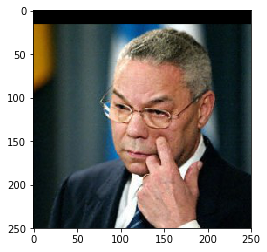

94658560/94653016 [==============================] - 1s 0us/step
A human was detected in the image. The human in this picture resembles a Silky terrier.


In [49]:
# Test the algorithm
dog_human_image_classification(human_files_short[22])

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

As indicated by the tests at the beginning of this notebook, both the human and the dog classifier seem to be very capable. Therefore, I am not too surprised that all six images were correctly classified as either dog, human, or neither of both.
While the German Shepherd was correctly detected in the last picture, the algorithm was not capable of correctly identifying the mini maltese in the first picture. However, the picture seems to be challenging since the wrongly identified Bichon frise looks very similar to the mini maltese.

To improve the algorithm, I would definitely try to increase the number of pictures that can be used for training. I suspect that this would be the most important adjustment to increase its performance.
Second, if more pictures are available, one could think about making the CNN more complex by adding additional layers.
Third, after executing these first two steps, I would pay special attention to the wrongly classified images and use them for additional training.

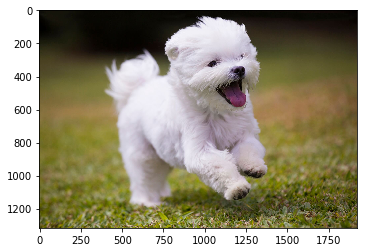

The dog in this picture seems to be a Bichon frise.


In [51]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# Image I
dog_human_image_classification('images/Mini_Malteser.jpg')

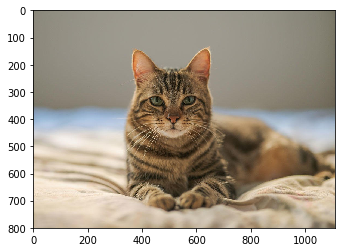

Unfortunately, neither a human nor a dog has been detected in the image. Have you made sure that either a picture of a dog or human has been provided?


In [52]:
# Image II
dog_human_image_classification('images/Katze_1.jpg')

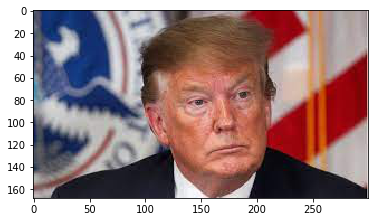

A human was detected in the image. The human in this picture resembles a Silky terrier.


In [53]:
# Image III
dog_human_image_classification('images/Donald_Trump.jpg')

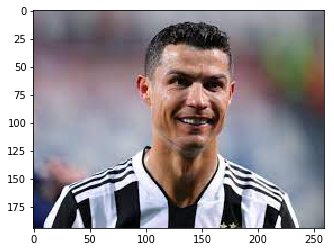

A human was detected in the image. The human in this picture resembles a Silky terrier.


In [57]:
# Image IV
dog_human_image_classification('images/Cristiano_Ronaldo.jpg')

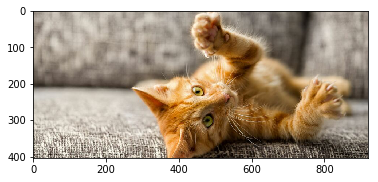

Unfortunately, neither a human nor a dog has been detected in the image. Have you made sure that either a picture of a dog or human has been provided?


In [55]:
# Image V
dog_human_image_classification('images/Katze_2.jpg')

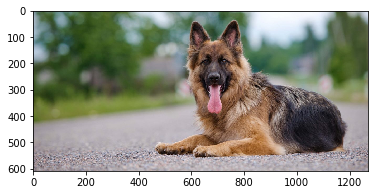

The dog in this picture seems to be a German shepherd dog.


In [56]:
# Image VI
dog_human_image_classification('images/Schaeferhund.jpg')